## Import Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from keras.models import Sequential

from tensorflow.keras import regularizers, optimizers

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import VGG19, efficientnet

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

### Import Dataset

In [5]:
from tensorflow.keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


### Pre-processsing data

There are 10 classes that are represented as unique integers and the class element of the data can therefore be one hot encoded.

Secondly the pixel values for each image are unsigned integers between 0 and 250. This is normalised to the range [0,1].

In [6]:
# One-Hot-Encoding
Y_train = to_categorical(Y_train,10)
Y_test = to_categorical(Y_test,10)

# Normalising
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255

In this assignment the test data will not be used for validation, instead a portion (20%) of the training data will be allocated as the validation data.

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

## Problem 1

For all models we used a batch_size of 400 and the number of epochs are 40.

Secondly in all our models we use max pooling layers. The reason for this is according to the textbook "Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow" by Aurélien Géron, even though average pooling layers used to be popular, a shift occurred to max pooling layer as they generally perform better. This is because even though average pooling layers keep more information by computing the mean, max pooling layers preserves only the strongest features so the next layer has a cleaner signal to work with.

### Model 1 - Baseline

This model will be used as the baseline model to compare the rest of the models to.

A good starting point is a VGG-style architecture. A VGG-style architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Each of these stacked convolutional layers and pooling layer pairs are refered to as blocks.

Below as our baseline we implement a 1-block VGG-style architecture.

In [5]:
model_1 =  Sequential([
    Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=(32,32,3)),
    Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(10, activation='softmax'),
], name='model_1')

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                           

In [6]:
model_1.compile(loss ="categorical_crossentropy", optimizer ="adam", metrics =["accuracy"])

In [7]:
history_1 = model_1.fit(X_train, Y_train, epochs = 40, verbose=1, validation_data=(X_val,Y_val), batch_size=400)

Epoch 1/40
100/100 [==============================] - 7s 21ms/step - loss: 1.9352 - accuracy: 0.3315 - val_loss: 1.5101 - val_accuracy: 0.4636
Epoch 2/40
100/100 [==============================] - 2s 17ms/step - loss: 1.3245 - accuracy: 0.5329 - val_loss: 1.2184 - val_accuracy: 0.5769
Epoch 3/40
100/100 [==============================] - 2s 17ms/step - loss: 1.1207 - accuracy: 0.6101 - val_loss: 1.1503 - val_accuracy: 0.6016
Epoch 4/40
100/100 [==============================] - 2s 17ms/step - loss: 1.0040 - accuracy: 0.6511 - val_loss: 1.0653 - val_accuracy: 0.6334
Epoch 5/40
100/100 [==============================] - 2s 17ms/step - loss: 0.9146 - accuracy: 0.6820 - val_loss: 1.0253 - val_accuracy: 0.6486
Epoch 6/40
100/100 [==============================] - 2s 19ms/step - loss: 0.8516 - accuracy: 0.7061 - val_loss: 0.9966 - val_accuracy: 0.6568
Epoch 7/40
100/100 [==============================] - 2s 19ms/step - loss: 0.8061 - accuracy: 0.7219 - val_loss: 0.9798 - val_accuracy: 0.6625

(0.0, 3.0)

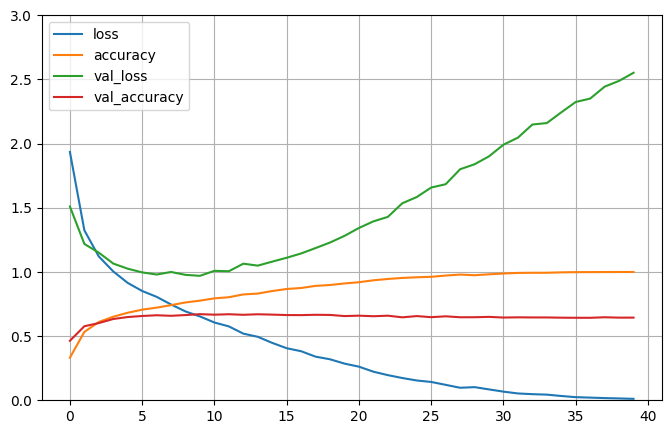

In [8]:
pd.DataFrame(history_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)

**Training Loss:** Continuously decreases across epochs, reaching a minimum of 0.0113.

**Training Accuracy:** Continuously increases across epochs, reaching nearly 100% by the final epochs.

**Validation Loss:** Initially decreases but starts increasing significantly from around epoch 10 onward, indicating overfitting.

**Validation Accuracy:** Remains relatively stable after the initial increase, eventually starting to drop.

From this we can conclude that a clear overfitting pattern is evident, since training loss decreases significantly, while validation loss starts increasing. Another indication is the validation accuracy does not improve and even declines slightly, which confirms overfitting.

The model obtained: Final Validation Accuracy: 64.4% and Best Validation Accuracy: 67.1% (Epoch 10).

### Model 2

2-block VGG-style architecture.

In [9]:
model_2 =  Sequential([
    Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=(32,32,3)),
    Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(10, activation='softmax'),
], name='model_2')

model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                      

In [10]:
model_2.compile(loss ="categorical_crossentropy", optimizer ="adam", metrics =["accuracy"])

In [11]:
history_2 = model_2.fit(X_train, Y_train, epochs = 40, verbose=1, validation_data=(X_val,Y_val), batch_size = 400)

Epoch 1/40
100/100 [==============================] - 6s 31ms/step - loss: 1.7565 - accuracy: 0.3764 - val_loss: 1.3897 - val_accuracy: 0.5004
Epoch 2/40
100/100 [==============================] - 3s 26ms/step - loss: 1.2638 - accuracy: 0.5503 - val_loss: 1.1828 - val_accuracy: 0.5833
Epoch 3/40
100/100 [==============================] - 3s 27ms/step - loss: 1.0767 - accuracy: 0.6202 - val_loss: 1.0337 - val_accuracy: 0.6380
Epoch 4/40
100/100 [==============================] - 3s 28ms/step - loss: 0.9307 - accuracy: 0.6767 - val_loss: 0.9472 - val_accuracy: 0.6723
Epoch 5/40
100/100 [==============================] - 3s 28ms/step - loss: 0.8405 - accuracy: 0.7075 - val_loss: 0.9641 - val_accuracy: 0.6643
Epoch 6/40
100/100 [==============================] - 3s 27ms/step - loss: 0.7583 - accuracy: 0.7371 - val_loss: 0.8752 - val_accuracy: 0.6975
Epoch 7/40
100/100 [==============================] - 3s 28ms/step - loss: 0.6881 - accuracy: 0.7609 - val_loss: 0.8826 - val_accuracy: 0.6968

(0.0, 3.0)

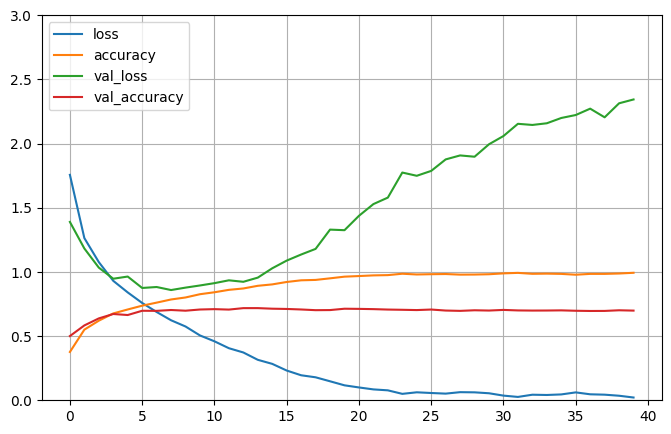

In [12]:
pd.DataFrame(history_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)

**Training Loss:** Continuously decreases across epochs, reaching a minimum of 0.0215.

**Training Accuracy:** Continuously increases across epochs, reaching nearly 100% by the final epochs.

**Validation Loss:** Initially decreases but starts increasing significantly from around epoch 7 onward, indicating overfitting.

**Validation Accuracy:** Remains relatively stable after the initial increase, eventually starting to drop.

From this we can conclude that a clear overfitting pattern is evident, since training loss decreases significantly, while validation loss starts increasing. Another indication is the validation accuracy does not improve and even declines slightly, which confirms overfitting.

The model obtained: Final Validation Accuracy: 69.87% and Best Validation Accuracy: 71.81% (Epoch 14). Model 2 therefore performed better than Model 1, but overfitting is still evident.

### Model 3

3-block VGG-style architecture.

In [13]:
model_3 =  Sequential([
    Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=(32,32,3)),
    Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(10, activation='softmax'),
], name='model_3')

model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                      

In [14]:
model_3.compile(loss ="categorical_crossentropy", optimizer ="adam", metrics =["accuracy"])

In [15]:
history_3 = model_3.fit(X_train, Y_train, epochs = 40, verbose=1, validation_data=(X_val,Y_val), batch_size = 400)

Epoch 1/40
100/100 [==============================] - 7s 38ms/step - loss: 1.7851 - accuracy: 0.3496 - val_loss: 1.4203 - val_accuracy: 0.4877
Epoch 2/40
100/100 [==============================] - 4s 35ms/step - loss: 1.3119 - accuracy: 0.5311 - val_loss: 1.2080 - val_accuracy: 0.5712
Epoch 3/40
100/100 [==============================] - 3s 33ms/step - loss: 1.0698 - accuracy: 0.6234 - val_loss: 1.1160 - val_accuracy: 0.6079
Epoch 4/40
100/100 [==============================] - 3s 34ms/step - loss: 0.8992 - accuracy: 0.6855 - val_loss: 0.9557 - val_accuracy: 0.6609
Epoch 5/40
100/100 [==============================] - 3s 35ms/step - loss: 0.7792 - accuracy: 0.7270 - val_loss: 0.8714 - val_accuracy: 0.6941
Epoch 6/40
100/100 [==============================] - 3s 35ms/step - loss: 0.6761 - accuracy: 0.7646 - val_loss: 0.8246 - val_accuracy: 0.7107
Epoch 7/40
100/100 [==============================] - 3s 35ms/step - loss: 0.5812 - accuracy: 0.7994 - val_loss: 0.7929 - val_accuracy: 0.7282

(0.0, 3.0)

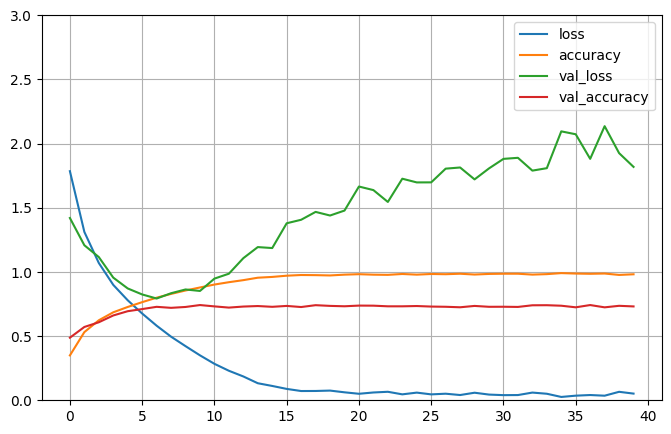

In [16]:
pd.DataFrame(history_3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)

**Training Loss:** Continuously decreases across epochs, reaching a minimum of 0.0520.

**Training Accuracy:** Continuously increases across epochs, reaching nearly 100% by the final epochs.

**Validation Loss:** Initially decreases but starts increasing significantly from around epoch 7 onward, indicating overfitting.

**Validation Accuracy:** Remains relatively stable after the initial increase, eventually starting to drop.

From this we can conclude that a clear overfitting pattern is evident, since training loss decreases significantly, while validation loss starts increasing. Another indication is the validation accuracy does not improve and even declines slightly, which confirms overfitting.

The model obtained: Final Validation Accuracy: 73.13% and Best Validation Accuracy: 74.20% (Epoch 37). Model 3 therefore performed better than Model 1 and Model 2, but overfitting is still evident.

It can be seen that increasing the number of blocks in the VGG-style architecture does increase the validation accuracy of the model, but all the models strugle with overfitting. Thus in order to improve the model performance we need to combat the overfitting.

### Model 4

3-block VGG-style architecture with dropout to combat overfitting.

In [18]:
model_4 =  Sequential([
    Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=(32,32,3)),
    Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(10, activation='softmax'),
], name='model_4')

model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 64)        36928     
                                                           

In [19]:
model_4.compile(loss ="categorical_crossentropy", optimizer ="adam", metrics =["accuracy"])

In [20]:
history_4 = model_4.fit(X_train, Y_train, epochs = 40, verbose=1, validation_data=(X_val,Y_val), batch_size = 400)

Epoch 1/40
100/100 [==============================] - 8s 48ms/step - loss: 2.1771 - accuracy: 0.1918 - val_loss: 1.9288 - val_accuracy: 0.2710
Epoch 2/40
100/100 [==============================] - 4s 43ms/step - loss: 1.7189 - accuracy: 0.3651 - val_loss: 1.5205 - val_accuracy: 0.4507
Epoch 3/40
100/100 [==============================] - 4s 43ms/step - loss: 1.4407 - accuracy: 0.4724 - val_loss: 1.3092 - val_accuracy: 0.5150
Epoch 4/40
100/100 [==============================] - 4s 43ms/step - loss: 1.2911 - accuracy: 0.5324 - val_loss: 1.1598 - val_accuracy: 0.5830
Epoch 5/40
100/100 [==============================] - 4s 42ms/step - loss: 1.1585 - accuracy: 0.5862 - val_loss: 1.0423 - val_accuracy: 0.6332
Epoch 6/40
100/100 [==============================] - 4s 44ms/step - loss: 1.0719 - accuracy: 0.6146 - val_loss: 1.0000 - val_accuracy: 0.6477
Epoch 7/40
100/100 [==============================] - 4s 44ms/step - loss: 0.9697 - accuracy: 0.6553 - val_loss: 0.9053 - val_accuracy: 0.6818

(0.0, 2.0)

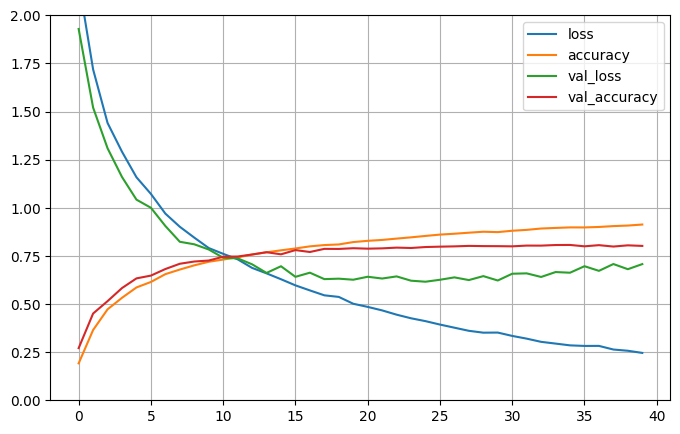

In [21]:
pd.DataFrame(history_4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)

**Training Loss:** Continuously decreases across epochs, reaching a minimum of 0.2460.

**Training Accuracy:** Continuously increases across epochs, reaching nearly 91.30% by the final epochs.

**Validation Loss:** Initially decreases, but stabilises around epoch 15 before gradually increasing again.

**Validation Accuracy:** Remains relatively stable after the initial increase.

The incorporation of dropout increased training loss slightly but maintained a high training accuracy. This indicates that the regularisation effect of dropout successfully combats overfitting without heavily impacting performance.

The model obtained: Final Validation Accuracy: 80.19% and Best Validation Accuracy: 80.69% (Epoch 35). Model 4 outperformed all the other Models, but even though dropout has improved overfitting drastically, it is still evident.

### Model 5

A second regularisation technique to test is L2 weight regularisation. This will be implemented in Model 5 below.

In [6]:
model_5 =  Sequential([
    Conv2D(filters=32, kernel_size=(3,3), kernel_regularizer=l2(0.001),  kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=(32,32,3)),
    Conv2D(filters=32, kernel_size=(3,3), kernel_regularizer=l2(0.001), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=(3,3), kernel_regularizer=l2(0.001), kernel_initializer='he_uniform', padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), kernel_regularizer=l2(0.001), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), kernel_regularizer=l2(0.001), kernel_initializer='he_uniform', padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3,3), kernel_regularizer=l2(0.001), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu',kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'),
    Dense(10, activation='softmax'),
], name='model_5')

model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                      

In [7]:
model_5.compile(loss ="categorical_crossentropy", optimizer ="adam", metrics =["accuracy"])

In [8]:
history_5 = model_5.fit(X_train, Y_train, epochs = 40, verbose=1, validation_data=(X_val,Y_val), batch_size = 400)

Epoch 1/40
100/100 [==============================] - 10s 34ms/step - loss: 2.6181 - accuracy: 0.3478 - val_loss: 2.1179 - val_accuracy: 0.4611
Epoch 2/40
100/100 [==============================] - 3s 29ms/step - loss: 1.9512 - accuracy: 0.5104 - val_loss: 1.7544 - val_accuracy: 0.5707
Epoch 3/40
100/100 [==============================] - 3s 30ms/step - loss: 1.6699 - accuracy: 0.5897 - val_loss: 1.6176 - val_accuracy: 0.6063
Epoch 4/40
100/100 [==============================] - 3s 30ms/step - loss: 1.5112 - accuracy: 0.6358 - val_loss: 1.4372 - val_accuracy: 0.6564
Epoch 5/40
100/100 [==============================] - 3s 30ms/step - loss: 1.3649 - accuracy: 0.6800 - val_loss: 1.3886 - val_accuracy: 0.6686
Epoch 6/40
100/100 [==============================] - 3s 30ms/step - loss: 1.2588 - accuracy: 0.7142 - val_loss: 1.3187 - val_accuracy: 0.6883
Epoch 7/40
100/100 [==============================] - 3s 30ms/step - loss: 1.1874 - accuracy: 0.7352 - val_loss: 1.2422 - val_accuracy: 0.709

(0.0, 2.0)

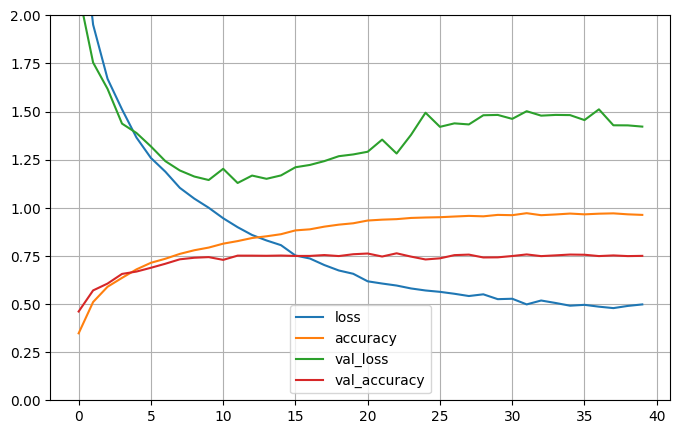

In [9]:
pd.DataFrame(history_5.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)

**Training Loss:** Continuously decreases across epochs, reaching a minimum of 0.4979.

**Training Accuracy:** Continuously increases across epochs, reaching nearly 96.31% by the final epochs.

**Validation Loss:** Initially decreases, but stabilises around epoch 10 before increasing again.

**Validation Accuracy:** Remains relatively stable after the initial increase.

The incorporation of L2-regularisation increased training loss slightly but maintained a high training accuracy. This indicates that the regularisation effect of L2-regularisation successfully combats overfitting without heavily impacting performance.

The model obtained: Final Validation Accuracy: 75.02% and Best Validation Accuracy: 76.35% (Epoch 23). Model 5 outperformed all the other Models except for Model 4, but even though L2-regularisation has improved overfitting drastically, it is still evident.

Both dropout and L2-regularisation seem to combat overfitting equally well, but since Model 4 had a better Best Validation Accuaracy, we will use this model and incorporate early stopping in attempt to completely overcome overfitting.

### Model 6

This model will make use of dropout and early stopping in atempt to overcome overfitting.

In [10]:
model_6 =  Sequential([
    Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=(32,32,3)),
    Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(10, activation='softmax'),
], name='model_6')

model_6.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                           

In [11]:
early_stopper = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

In [12]:
model_6.compile(loss ="categorical_crossentropy", optimizer ="adam", metrics =["accuracy"])

In [13]:
history_6 = model_6.fit(X_train, Y_train, epochs = 40, verbose=1, validation_data=(X_val,Y_val), batch_size = 400, callbacks=[early_stopper])

Epoch 1/40
100/100 [==============================] - 8s 47ms/step - loss: 2.1040 - accuracy: 0.2142 - val_loss: 1.7333 - val_accuracy: 0.3588
Epoch 2/40
100/100 [==============================] - 4s 42ms/step - loss: 1.5859 - accuracy: 0.4144 - val_loss: 1.4504 - val_accuracy: 0.4754
Epoch 3/40
100/100 [==============================] - 4s 44ms/step - loss: 1.3682 - accuracy: 0.4999 - val_loss: 1.2410 - val_accuracy: 0.5595
Epoch 4/40
100/100 [==============================] - 5s 46ms/step - loss: 1.2202 - accuracy: 0.5629 - val_loss: 1.1233 - val_accuracy: 0.5931
Epoch 5/40
100/100 [==============================] - 4s 42ms/step - loss: 1.0956 - accuracy: 0.6062 - val_loss: 1.0211 - val_accuracy: 0.6402
Epoch 6/40
100/100 [==============================] - 4s 42ms/step - loss: 1.0091 - accuracy: 0.6402 - val_loss: 0.9527 - val_accuracy: 0.6647
Epoch 7/40
100/100 [==============================] - 4s 41ms/step - loss: 0.9457 - accuracy: 0.6633 - val_loss: 0.8634 - val_accuracy: 0.6940

(0.0, 2.0)

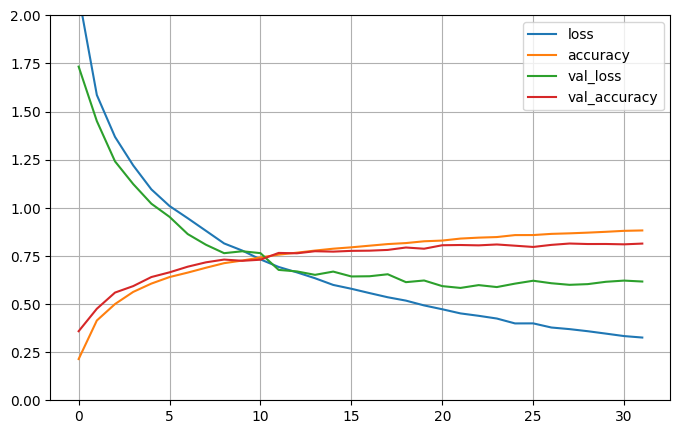

In [14]:
pd.DataFrame(history_6.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)

As can be seen, by incorporating dropout and early stopping we removed overfitting. This model outperformed all the other models with Validation accuracy of 80.66% and Validation loss of 0.5837.

Therefore Model 6 is our chosen model and will now be evaluated on the test set.

### Model 6 Evaluation.

In [16]:
test_loss, test_accuracy = model_6.evaluate(X_test, Y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.5920 - accuracy: 0.7970
Test Loss: 0.5920141339302063
Test Accuracy: 0.796999990940094


Model 6 yielded a test accuracy of roughly 80%. This is an excellent result and is an indication of how well our model generalises.

## Problem 2

### Model 7

We will make use of the VGG model available in keras. The reason for this is this model also makes use of the VGG architecture described earlier. It will be intersting to see how increasing the number of blocks as in the VGG model affects the models accuracy.

In [30]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False

In [31]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

The VGG19 network, designed for ImageNet, expects input images of size 224x224 pixels. However, CIFAR-10 images are 32x32 pixels. By specifying input_shape=(32, 32, 3), you are explicitly informing the model to adjust its initial convolutional layers to accept smaller images. Without this adjustment, the model would not accept the CIFAR-10 image size as input.

In [32]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(10, activation='softmax')
])

In [33]:
model.compile(loss ="categorical_crossentropy", optimizer ="adam", metrics =["accuracy"])

In [34]:
history = model.fit(X_train, Y_train, epochs=40, verbose=1, validation_data=(X_val, Y_val), batch_size=400)

Epoch 1/40
100/100 [==============================] - 8s 67ms/step - loss: 1.6762 - accuracy: 0.4186 - val_loss: 1.4439 - val_accuracy: 0.4978
Epoch 2/40
100/100 [==============================] - 6s 61ms/step - loss: 1.3721 - accuracy: 0.5247 - val_loss: 1.3476 - val_accuracy: 0.5255
Epoch 3/40
100/100 [==============================] - 6s 62ms/step - loss: 1.2952 - accuracy: 0.5524 - val_loss: 1.3099 - val_accuracy: 0.5369
Epoch 4/40
100/100 [==============================] - 6s 63ms/step - loss: 1.2478 - accuracy: 0.5681 - val_loss: 1.2720 - val_accuracy: 0.5522
Epoch 5/40
100/100 [==============================] - 6s 63ms/step - loss: 1.2197 - accuracy: 0.5756 - val_loss: 1.2537 - val_accuracy: 0.5627
Epoch 6/40
100/100 [==============================] - 6s 63ms/step - loss: 1.1967 - accuracy: 0.5843 - val_loss: 1.2306 - val_accuracy: 0.5697
Epoch 7/40
100/100 [==============================] - 6s 63ms/step - loss: 1.1718 - accuracy: 0.5941 - val_loss: 1.2281 - val_accuracy: 0.5692

(0.0, 3.0)

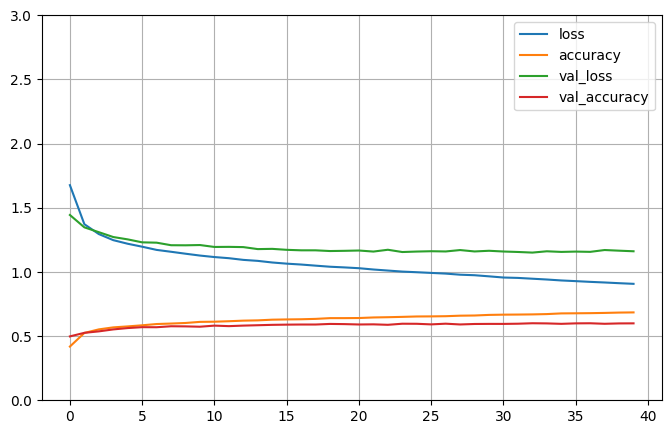

In [35]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)

As you can see this model has definitely not improved on Model 6. A reason for this can be the fact that the convolutional layers are not being trained.

As for training time, I do not see a significant improvement in training time when using the pre-trained model. This might be becuase in this report we are using Google Colabs T4 GPU, this is a very powerfull GPU for training deep learning models (As you can see in the training times provided in the Epochs).

### Model 8

To try and improve on the Model 7 that made use of transfer learning, we will set the last 4 convolution layers as trainable. We will also add early stopping and dropout to the Model to mitigate overfitting.

In [23]:
early_stopper = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

In [47]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [48]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

In [49]:
model.compile(loss ="categorical_crossentropy", optimizer ="adam", metrics =["accuracy"])

In [50]:
history = model.fit(X_train, Y_train, epochs=40, verbose=1, validation_data=(X_val, Y_val), batch_size=400, callbacks=[early_stopper])

Epoch 1/40
100/100 [==============================] - 10s 84ms/step - loss: 1.6638 - accuracy: 0.3979 - val_loss: 1.1688 - val_accuracy: 0.5980
Epoch 2/40
100/100 [==============================] - 8s 79ms/step - loss: 1.0805 - accuracy: 0.6317 - val_loss: 0.9603 - val_accuracy: 0.6714
Epoch 3/40
100/100 [==============================] - 8s 79ms/step - loss: 0.9368 - accuracy: 0.6819 - val_loss: 0.9274 - val_accuracy: 0.6753
Epoch 4/40
100/100 [==============================] - 8s 81ms/step - loss: 0.8347 - accuracy: 0.7140 - val_loss: 0.9115 - val_accuracy: 0.6912
Epoch 5/40
100/100 [==============================] - 8s 81ms/step - loss: 0.7616 - accuracy: 0.7371 - val_loss: 0.8828 - val_accuracy: 0.6963
Epoch 6/40
100/100 [==============================] - 8s 80ms/step - loss: 0.7062 - accuracy: 0.7596 - val_loss: 0.8794 - val_accuracy: 0.6974
Epoch 7/40
100/100 [==============================] - 8s 79ms/step - loss: 0.6488 - accuracy: 0.7752 - val_loss: 0.9355 - val_accuracy: 0.701

(0.0, 3.0)

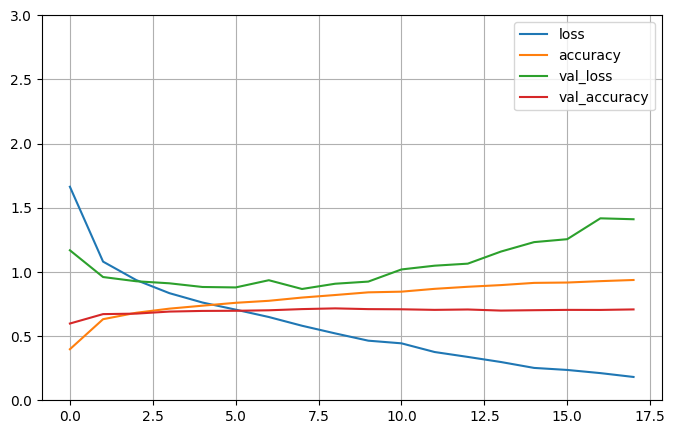

In [51]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)

In [52]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

313/313 [==============================] - 4s 11ms/step - loss: 0.8848 - accuracy: 0.7111
Test Loss: 0.8848167061805725
Test Accuracy: 0.7110999822616577


By allowing some of the convolutional layers to train and by adding dropout and early stopping, we have definetly improved on Model 7.

Even though we improved on Model 7, this Model does not outperform Model 6.

**To conclude:**

Reasons why the VGG19 model might not perform well on the CIFAR-10 dataset are:


*   VGG19 has a deep and complex architecture, with over 140 million parameters, this leads to overfitting on smaller datasets due to its limited number of training examples
*    Input size mismatch, as it is designed for larger ImageNet images of 224x224, while CIFAR-10 images are only 32x32.

